# Imports

In [1]:
import os
import cv2
import time
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, classification_report

# Reading Data

In [2]:
def load_df(path):
    x, y = [], []
    
    for folder in tqdm(os.listdir(path)):
        for file in os.listdir(f'{path}/{folder}'):
            x.append(f'{path}/{folder}/{file}')
            y.append(folder)
        
    dataset = {
        'image': x,
        'label': y
    }
    
    return pd.DataFrame(dataset)

In [4]:
root_path = './slash-dataset/slash-dataset-480p'

slash_df = load_df(root_path)
slash_df['id'] = slash_df['image'].str.split('/').str[-1].str.split('.').str[0]

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3000.58it/s]


In [5]:
print(slash_df.shape)
slash_df.head()

(478, 3)


,image,label,id
0,./slash-dataset/slash-dataset-480p/accessory/0...,accessory,0
1,./slash-dataset/slash-dataset-480p/accessory/1...,accessory,1
2,./slash-dataset/slash-dataset-480p/accessory/1...,accessory,10
3,./slash-dataset/slash-dataset-480p/accessory/1...,accessory,100
4,./slash-dataset/slash-dataset-480p/accessory/1...,accessory,101


In [6]:
X = []
time1 = time.time()

for i, img_path in enumerate(slash_df.image):    
    #cv2 read images as BGR that should be converted into RGB
    img = cv2.imread(img_path)[:,:,::-1]
    X.append(img)
    
time2 = time.time()
time3 = np.round(time2 - time1)
print(time3, "sec")

1.0 sec


# EDA

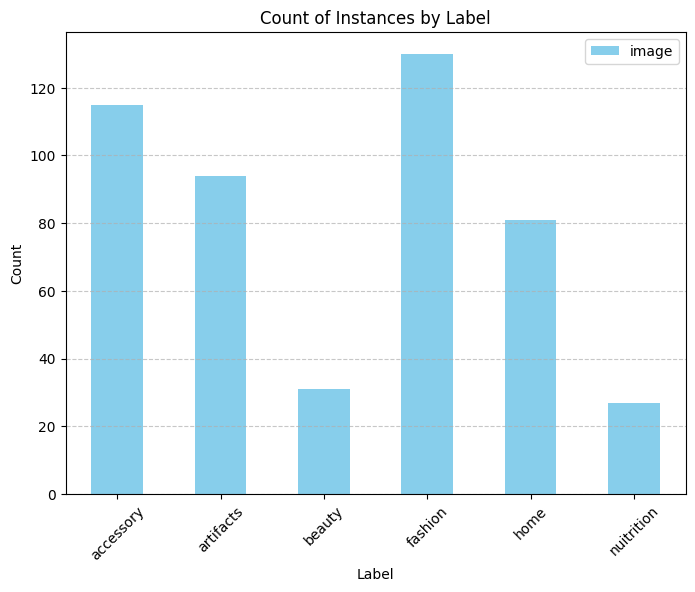

In [7]:
# Grouping by label and counting instances
selected_columns = ['image', 'label']
label_counts = slash_df[selected_columns].groupby('label').count()

# Plotting the bar chart
label_counts.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Count of Instances by Label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Data Preparation

In [8]:
SHAPE = X[0].shape[0]
BATCH_SIZE = 8
SHUFFLE_SIZE = 1_000

In [9]:
# To Interpret the prediction result
def get_category(y_hat, cols):
    max_value = y_hat.max()
    for index, category in enumerate(y_hat):
        if category == max_value:
            return cols[index]
    
    return 'unknown'

def augment_image(image, label):
    # Randomly flip the image horizontally
    img = tf.image.random_flip_left_right(image)
    
    # Randomly flip the image vertically
    img = tf.image.random_flip_up_down(img)
    
    # Randomly adjust the brightness of the image
    img = tf.image.random_brightness(img, max_delta=0.2)
    
    # Randomly adjust the saturation of the image
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    
    return img, label

def tensor_slices_dataset(x, y, shuffle_size = SHUFFLE_SIZE, batch_size = BATCH_SIZE, training=False):
    data = tf.data.Dataset.from_tensor_slices((x, y))
    
    if training:
        augmented_data = data.map(augment_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        data = data.concatenate(augmented_data)

        
    data = data.shuffle(shuffle_size)
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)
    
    return data

In [10]:
# Divide each pixel value by 255 to normalize it to the range [0, 1]
if X[0].dtype == 'uint8':
    for index in tqdm(range(len(X))):
        normalized_image = X[index] / 255.0
        rounded_image = np.round(normalized_image, decimals=5)

        X[index] = rounded_image

100%|███████████████████████████████████████████████████████████████████████████████| 478/478 [00:03<00:00, 138.68it/s]


In [11]:
# One-Hot-Encoded labels
y = pd.get_dummies(slash_df['label'])
_columns = y.columns 

print(_columns)
y.head()

Index(['accessory', 'artifacts', 'beauty', 'fashion', 'home', 'nuitrition'], dtype='object')


,accessory,artifacts,beauty,fashion,home,nuitrition
0,True,False,False,False,False,False
1,True,False,False,False,False,False
2,True,False,False,False,False,False
3,True,False,False,False,False,False
4,True,False,False,False,False,False


In [12]:
# Split the data into training, and validating sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=slash_df['label'])
print(y_train.shape, y_val.shape)

(382, 6) (96, 6)


accessory     False
artifacts     False
beauty        False
fashion        True
home          False
nuitrition    False
Name: 355, dtype: bool


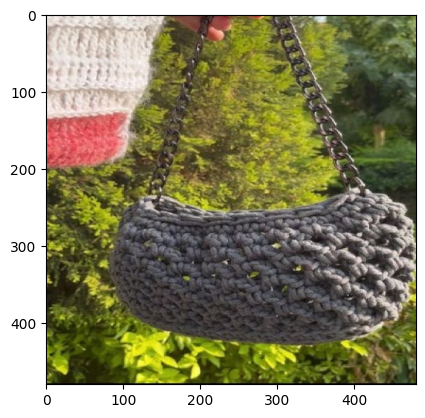

In [13]:
# Viewing a random sample
idx = random.randint(0, y_train.shape[0] - 1)

print(y_train.iloc[idx])
plt.imshow(X_train[idx])

In [14]:
# Generating tensor-dataset to train model with
train_tensor = tensor_slices_dataset(X_train, y_train, training=True)
val_tensor = tensor_slices_dataset(X_val, y_val)

train_tensor.take(1) # Sample

<TakeDataset element_spec=(TensorSpec(shape=(None, 480, 480, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 6), dtype=tf.bool, name=None))>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


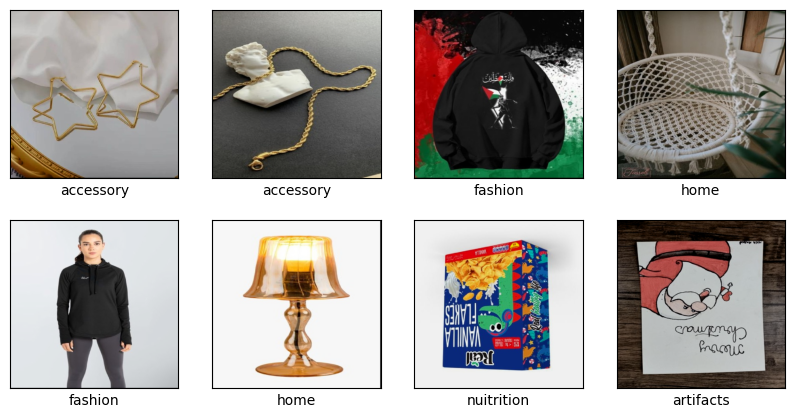

In [15]:
for x, y in train_tensor.take(1):
    plt.figure(figsize=(10,5))
    
    for i in range(8):                
        plt.subplot(2, 4, i+1)
        plt.imshow(x[i])
        
        plt.xlabel(get_category(np.array(y[i]), _columns))
        plt.xticks([])
        plt.yticks([])      

# Model Building

In [18]:
best_model_filepath = './model/model_checkpoint.h5'
log_dir = "/./model/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
# Using TransferLearning 'InceptionResNetV2'
# base_model = tf.keras.applications.InceptionResNetV2(include_top=False, input_shape=(SHAPE, SHAPE, 3))
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(SHAPE, SHAPE, 3))
base_model.trainable = False

# base_model.summary()
# tf.keras.utils.plot_model(base_model, to_file='./logs/InceptionResNetV2.jpg')

In [20]:
# building model up using functional apis
input_layer = tf.keras.layers.Input(shape=(SHAPE, SHAPE, 3))

tl_model = base_model(input_layer, training=False)

x = tf.keras.layers.Flatten()(tl_model)

x = tf.keras.layers.Dense(units=256, activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dense(units=128, activation='leaky_relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer = tf.keras.layers.Dense(units=_columns.shape[0], activation='softmax')(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 15, 15, 1024)      7037504   
                                                                 
 flatten (Flatten)           (None, 230400)            0         
                                                                 
 dense (Dense)               (None, 256)               58982656  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                             

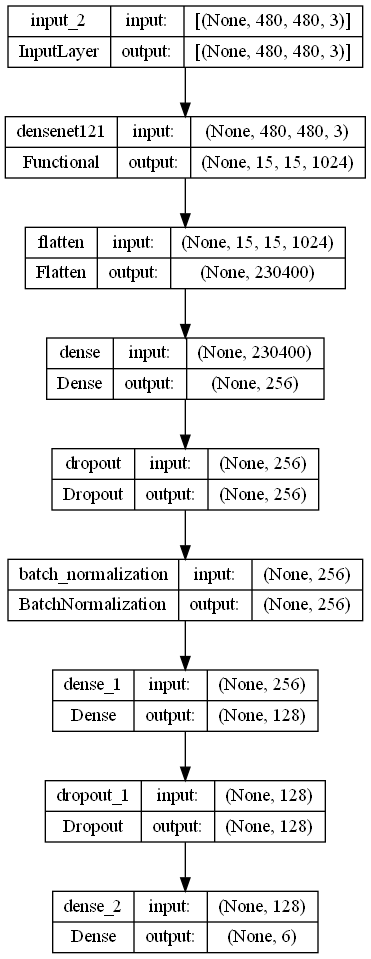

In [22]:
# Plotting model
tf.keras.utils.plot_model(model, to_file='./model/model_plot.png', show_shapes=True, show_layer_names=True)

# Model Training

In [23]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
# Training model
model.fit(train_tensor,
          batch_size=BATCH_SIZE,
          epochs=10,
          validation_data=val_tensor,
          callbacks = [tensorboard_callback, model_checkpoint_callback])

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.3956 - acc: 0.4882
Epoch 1: val_loss improved from inf to 0.72310, saving model to ./model\model_checkpoint.h5
96/96 [==============================] - 133s 1s/step - loss: 1.3956 - acc: 0.4882 - val_loss: 0.7231 - val_acc: 0.7604
Epoch 2/10
17/96 [====>.........................] - ETA: 9s - loss: 0.8607 - acc: 0.7353

In [ ]:
# # TensorBoard
# # Killing any running session of tensorboard
# !del /q %TMP%\.tensorboard-info\*

# # Loading the Tensorboard extension
# %load_ext tensorboard
# %tensorboard --logdir "./logs"

# Model Testing

In [29]:
# Load the saved model
model = load_model('/kaggle/working/model/model_checkpoint.keras')

# Testing our model
test_loss, test_accuracy = model.evaluate(val_tensor)

# Printing the test results
print('Test loss: {0:.4f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 742 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


 2/12 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - acc: 1.0000 - loss: 0.0973

W0000 00:00:1711118904.171959     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 97ms/step - acc: 0.9745 - loss: 0.1252
Test loss: 0.1681. Test accuracy: 93.75%


In [33]:
# Assuming you have already trained your model and have predictions on the validation data
predictions = model.predict(val_tensor)
y_true = np.argmax(y_val, axis=1)  # Assuming y_val is one-hot encoded

# Convert predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculate precision and recall for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)

# Calculate true positives, true negatives, false positives, and false negatives for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Print metrics
print("Precision:", precision)
print("Recall:", recall)

# Print classification report
print(classification_report(y_true, y_pred))

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step

W0000 00:00:1711118971.376000     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step
Precision: [0.39130435 0.05263158 0.         0.28       0.11111111 0.16666667]
Recall: [0.39130435 0.05263158 0.         0.26923077 0.125      0.16666667]
              precision    recall  f1-score   support

           0       0.39      0.39      0.39        23
           1       0.05      0.05      0.05        19
           2       0.00      0.00      0.00         6
           3       0.28      0.27      0.27        26
           4       0.11      0.12      0.12        16
           5       0.17      0.17      0.17         6

    accuracy                           0.21        96
   macro avg       0.17      0.17      0.17        96
weighted avg       0.21      0.21      0.21        96



# Prediction Phase

In [95]:
#  To read image
def read_image(img_path, _shape = SHAPE):
    img = cv2.imread(img_path)[:,:,::-1]
    img = cv2.resize(img, (_shape, _shape))
    img = np.round(img / 255, decimals=5)
    return img

# To Interpret the prediction result
def get_category(y_hat, cols):
    max_value = y_hat.max()
    for index, category in enumerate(y_hat):
        if category == max_value:
            return cols[index]
    
    return 'unknown'
    
def make_prediction(model, image, cols = ['accessory', 'artifacts', 'beauty', 'fashion', 'home', 'nuitrition']):
    # Make a prediction
    predictions = model.predict(tf.expand_dims(image, 0))

    # Display The prediction
    print(f'the image is {get_category(predictions[0], cols)}')
    
    plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
the image is home


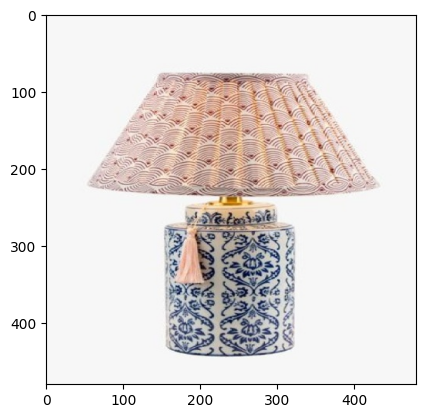

In [97]:
# Predicting on the validation dataset
make_prediction(model, X_val[24])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
the image is accessory


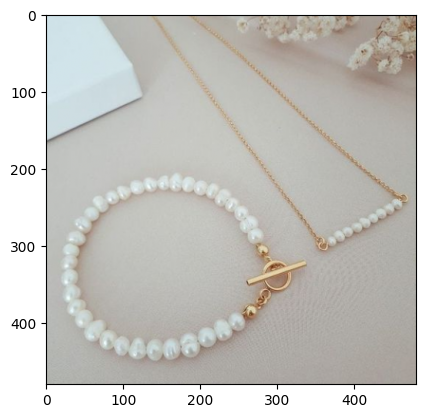

In [127]:
# Predicting on the test dataset
test_img = read_image('/kaggle/input/slash-dataset/test-images/accessory/test_image (3).jpg')
make_prediction(model, test_img)